In [8]:
import pandas as pd
import seaborn as sns
from main import preprocess

In [9]:
df, df_small, source = preprocess(0, 128)

In [3]:
df.iloc[0]

age               0.301370
workclass         0.625000
education-num     0.800000
capital-gain      0.021740
capital-loss      0.000000
hours-per-week    0.397959
50K               0.000000
Name: 0, dtype: float64

In [10]:
df_small.iloc[source]

age               3.648402e-01
workclass         6.250000e-01
education-num     8.277778e-01
capital-gain      8.953340e-03
capital-loss     -2.428613e-17
hours-per-week    4.069728e-01
50K               0.000000e+00
Name: 52, dtype: float64

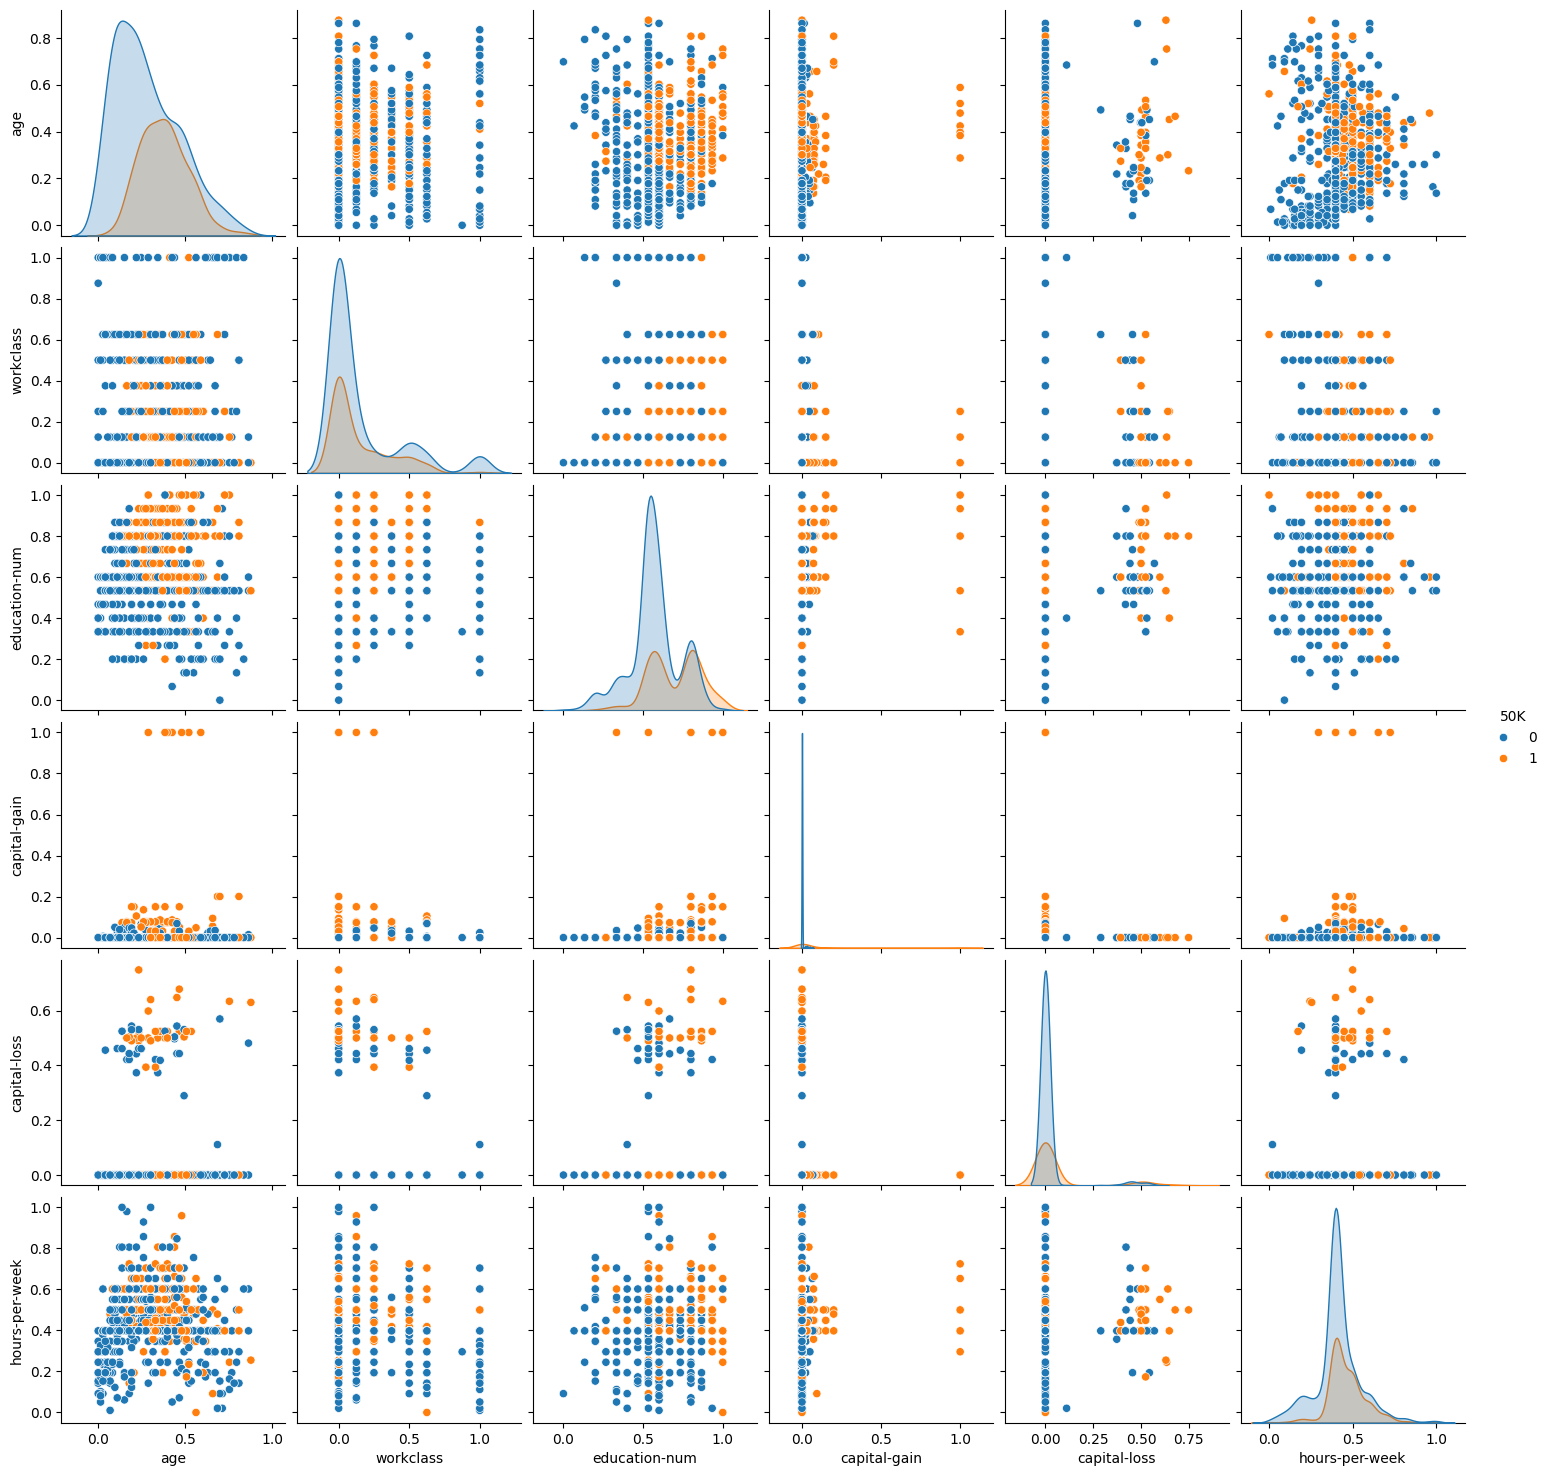

In [5]:
sns.pairplot(df.sample(1000), hue="50K")

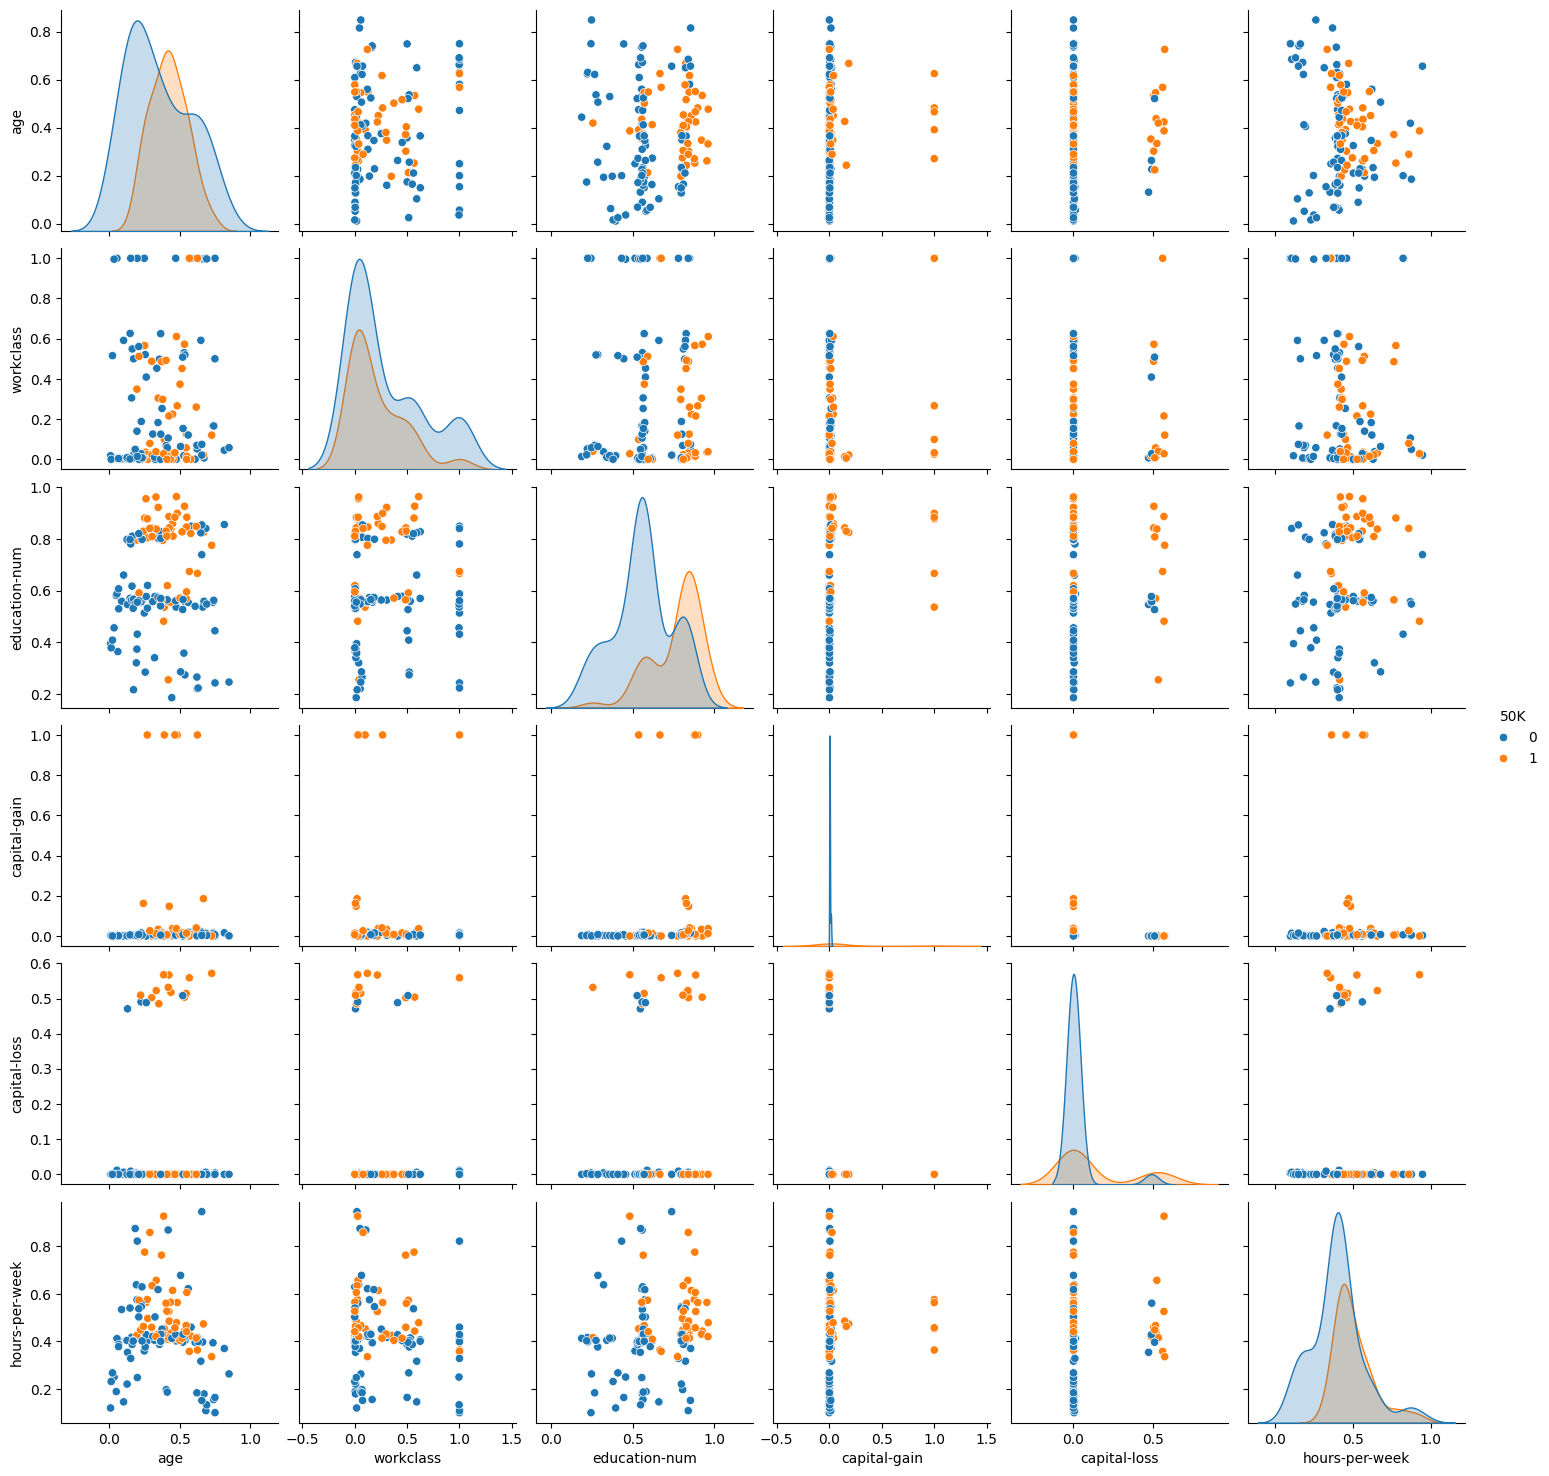

In [6]:
sns.pairplot(df_small, hue="50K")

In [7]:
df.describe()

,age,workclass,education-num,capital-gain,capital-loss,hours-per-week,50K
count,17653.000000,17653.000000,17653.000000,17653.000000,17653.000000,17653.000000,17653.000000
mean,0.312178,0.133901,0.617666,0.014086,0.027814,0.425856,0.325157
std,0.184411,0.256048,0.165146,0.086013,0.116493,0.125438,0.468447
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.164384,0.000000,0.533333,0.000000,0.000000,0.397959,0.000000
50%,0.287671,0.000000,0.600000,0.000000,0.000000,0.397959,0.000000
75%,0.438356,0.125000,0.800000,0.000000,0.000000,0.500000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
df_small.describe()

,age,workclass,education-num,capital-gain,capital-loss,hours-per-week,50K
count,128.000000,1.280000e+02,128.000000,1.280000e+02,1.280000e+02,128.000000,128.000000
mean,0.375957,2.596937e-01,0.632092,4.898433e-02,6.529680e-02,0.438901,0.351562
std,0.198784,3.279952e-01,0.196631,1.941601e-01,1.726476e-01,0.163021,0.479334
min,0.010910,-1.665335e-16,0.185827,-1.908196e-17,-3.816392e-17,0.100219,0.000000
25%,0.211934,9.977640e-03,0.540380,1.495890e-03,-2.428613e-17,0.392769,0.000000
50%,0.365310,7.197375e-02,0.577389,4.795668e-03,-1.387779e-17,0.414707,0.000000
75%,0.530490,4.985577e-01,0.812570,8.738837e-03,6.938894e-18,0.503304,1.000000
max,0.849315,1.000000e+00,0.963522,1.000000e+00,5.716672e-01,0.946429,1.000000


In [11]:
from algo import recourse


In [12]:
recourse(df_small, source)